In [1]:
import tensorflow as tf
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Data

In [2]:
def loadData():
    data = io.loadmat("face_landmark.mat")
    images = data["images"]
    landmarks = data["landmarks"]
    print("im_shape:", images.shape)
    print("landmarks_shape:", landmarks.shape)

    return images, landmarks

In [3]:
images, landmarks = loadData()

im_shape: (2140, 96, 96)
landmarks_shape: (2140, 15, 2)


# Visualize Data

In [4]:
def visualize_data(images, landmarks, num_images):
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(num_images):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
        for (x, y) in landmarks[i].reshape(-1, 2):
            # Plot keypoints/landmarks on the image
            ax.scatter(x, y, marker='o', s=10, color='r')

    plt.show()

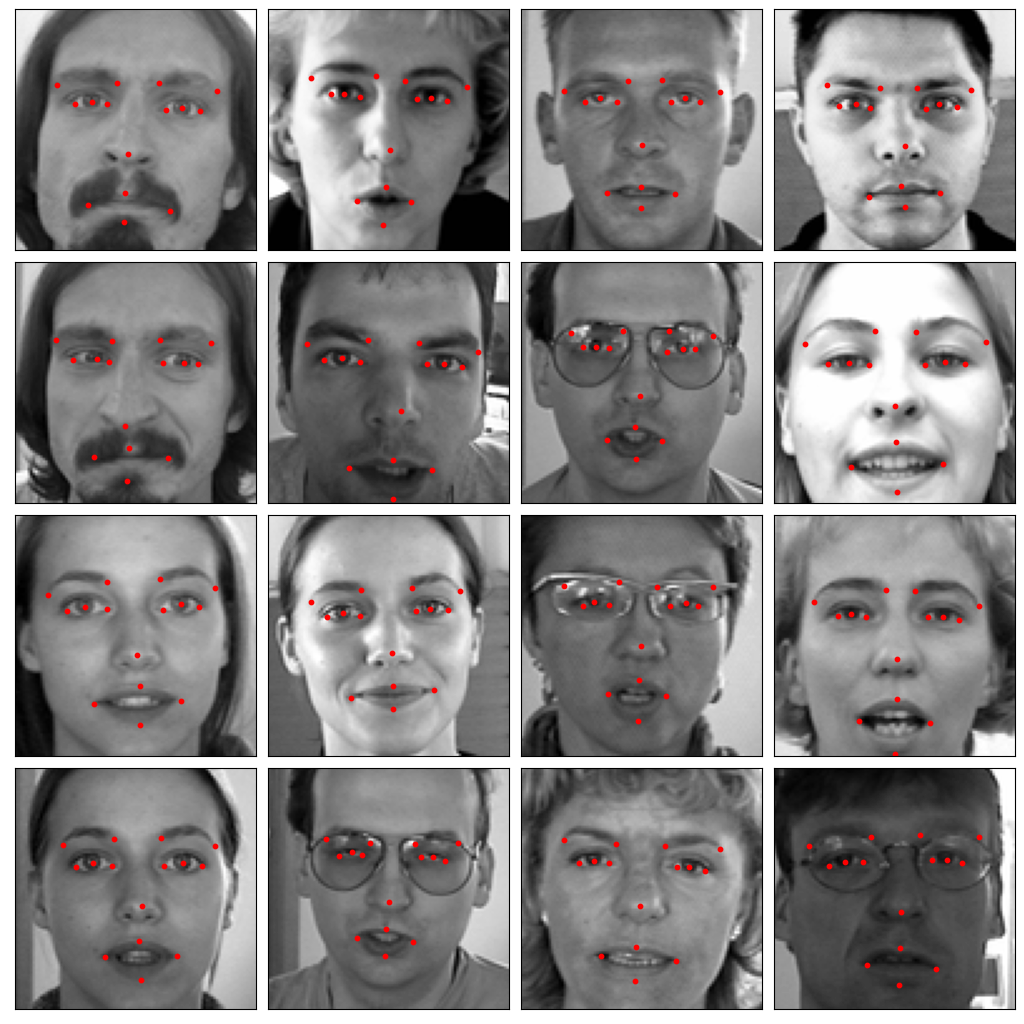

In [5]:
visualize_data(images, landmarks, num_images=16)

# Preprocessing

### split

In [6]:
def split_data(data, size):
    np.random.seed(2023)
    
    idx = np.random.permutation(size)

    train_size = int(size * 0.6)
    val_size = int(size * 0.2)
    test_size = int(size * 0.2)

    train_ds = data[idx[: train_size]]
    val_ds = data[idx[train_size: train_size + val_size]]
    test_ds = data[idx[size - test_size:]]

    return train_ds, val_ds, test_ds

In [7]:
train_img, val_img, test_img = split_data(images, images.shape[0])

In [8]:
train_lmrk, val_lmrk, test_lmrk = split_data(landmarks, landmarks.shape[0])

### Reshape

In [9]:
print(train_img.shape)
print(train_lmrk.shape)

(1284, 96, 96)
(1284, 15, 2)


In [10]:
print(val_img.shape)
print(val_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [11]:
print(test_img.shape)
print(test_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [12]:
train_lmrk = train_lmrk.reshape((1284, -1))
val_lmrk = val_lmrk.reshape((428, -1))
test_lmrk = test_lmrk.reshape((428, -1))

In [13]:
print(train_lmrk.shape)
print(val_lmrk.shape)
print(test_lmrk.shape)

(1284, 30)
(428, 30)
(428, 30)


# Model
* Output은 15개의 얼굴 랜드마크에 해당하는 x, y 좌표이므로 총 30개의 출력 유닛이 필요

In [14]:
# Define the input shape
input_layer = tf.keras.Input(shape=(96, 96, 1))

# Define the convolution and pooling layers
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the tensor output for the Fully Connected layer
x = tf.keras.layers.Flatten()(x)

# Define the fully connected layer
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Define the output layer (30 units for 15 landmarks x and y coordinates)
output_layer = tf.keras.layers.Dense(30)(x)

# Create the model
model = tf.keras.Model(input_layer, output_layer)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496 

## Predict

In [15]:
@tf.function
def predict(x):
    return model(x, training=False)

# Optimization

In [16]:
@tf.function
def optimize(x,y_true,loss_function):
    with tf.GradientTape() as tape:
        y_pred = predict(x)
        loss = loss_function(y_pred, y_true)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Loss
* 실제 레이블(y_true)와 모델의 예측 결과(y)를 입력

In [18]:
@tf.function
def l1_loss(y_pred, y_true):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

@tf.function
def l2_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_true - y_pred))

@tf.function
def cosine_loss(y_pred, y_true):
    # Normalize each vector
    y_true_normalized = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_normalized = tf.nn.l2_normalize(y_pred, axis=-1)
    # Compute the dot product (cosine similarity)
    dot_product = tf.reduce_sum(y_true_normalized * y_pred_normalized, axis=-1)
    # Subtract the dot product from 1 to get the loss
    return 1 - tf.reduce_mean(dot_product)


In [19]:
def combine_l2_loss(y_pred, y_true, lamda):
    return l2_loss(y_pred, y_true) + lamda*cosine_loss(y_pred, y_true)

# Train & Evaluation

## L1 Loss

In [20]:
""" start training """
loss_function = l1_loss

max_epochs = 1000
batch_size = 32


loss_history = []
val_loss_best = np.inf
train_size = int(images.shape[0] * 0.6)

#Early stopping hyperparameter
patience = 50  # number of epochs to wait before stopping if there is no improvement
wait = 0  # counter for epochs without improvement


for epoch in range(max_epochs):
    # get a minibatch
    idx = np.random.permutation(train_size)
    batch_idx = idx[:batch_size]

    # optimize
    train_loss = optimize(train_img[batch_idx], train_lmrk[batch_idx], loss_function)
    train_loss = train_loss.numpy()

    # evaluate on val_set
    y = predict(val_img)
    val_loss = loss_function(y, val_lmrk).numpy()

    # Early stopping check
    if val_loss < val_loss_best:
        val_loss_best = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
        
    print('Epoch:', epoch, '. Training Loss:', train_loss, ' Validation Loss:', val_loss, ' Best Validation Loss:', val_loss_best)
    loss_history.append([train_loss, val_loss])

Epoch: 0 . Training Loss: 47.547573  Validation Loss: 38.996716  Best Validation Loss: 38.996716
Epoch: 1 . Training Loss: 39.059414  Validation Loss: 30.120283  Best Validation Loss: 30.120283
Epoch: 2 . Training Loss: 30.576565  Validation Loss: 25.48208  Best Validation Loss: 25.48208
Epoch: 3 . Training Loss: 25.98934  Validation Loss: 21.585094  Best Validation Loss: 21.585094
Epoch: 4 . Training Loss: 21.372225  Validation Loss: 18.961628  Best Validation Loss: 18.961628
Epoch: 5 . Training Loss: 19.246685  Validation Loss: 17.669249  Best Validation Loss: 17.669249
Epoch: 6 . Training Loss: 17.63233  Validation Loss: 16.52272  Best Validation Loss: 16.52272
Epoch: 7 . Training Loss: 15.880998  Validation Loss: 15.678935  Best Validation Loss: 15.678935
Epoch: 8 . Training Loss: 15.922944  Validation Loss: 14.258332  Best Validation Loss: 14.258332
Epoch: 9 . Training Loss: 14.264251  Validation Loss: 13.688193  Best Validation Loss: 13.688193
Epoch: 10 . Training Loss: 12.466321

Epoch: 86 . Training Loss: 6.98658  Validation Loss: 9.020506  Best Validation Loss: 7.904372
Epoch: 87 . Training Loss: 9.182944  Validation Loss: 7.849798  Best Validation Loss: 7.849798
Epoch: 88 . Training Loss: 9.040999  Validation Loss: 9.607416  Best Validation Loss: 7.849798
Epoch: 89 . Training Loss: 9.601871  Validation Loss: 9.497052  Best Validation Loss: 7.849798
Epoch: 90 . Training Loss: 8.33687  Validation Loss: 7.792484  Best Validation Loss: 7.792484
Epoch: 91 . Training Loss: 8.8617735  Validation Loss: 10.519073  Best Validation Loss: 7.792484
Epoch: 92 . Training Loss: 11.546224  Validation Loss: 10.820571  Best Validation Loss: 7.792484
Epoch: 93 . Training Loss: 11.610865  Validation Loss: 8.098056  Best Validation Loss: 7.792484
Epoch: 94 . Training Loss: 7.1869216  Validation Loss: 8.23828  Best Validation Loss: 7.792484
Epoch: 95 . Training Loss: 6.8031697  Validation Loss: 10.414862  Best Validation Loss: 7.792484
Epoch: 96 . Training Loss: 10.278695  Validat

Epoch: 171 . Training Loss: 6.2437115  Validation Loss: 7.723277  Best Validation Loss: 7.3096666
Epoch: 172 . Training Loss: 6.731959  Validation Loss: 7.871477  Best Validation Loss: 7.3096666
Epoch: 173 . Training Loss: 7.8880777  Validation Loss: 7.3319144  Best Validation Loss: 7.3096666
Epoch: 174 . Training Loss: 6.3517346  Validation Loss: 7.3642206  Best Validation Loss: 7.3096666
Epoch: 175 . Training Loss: 6.1067214  Validation Loss: 7.4305334  Best Validation Loss: 7.3096666
Epoch: 176 . Training Loss: 7.657759  Validation Loss: 7.280189  Best Validation Loss: 7.280189
Epoch: 177 . Training Loss: 7.8200793  Validation Loss: 7.2889543  Best Validation Loss: 7.280189
Epoch: 178 . Training Loss: 7.2367725  Validation Loss: 7.3268642  Best Validation Loss: 7.280189
Epoch: 179 . Training Loss: 6.4210033  Validation Loss: 7.5147943  Best Validation Loss: 7.280189
Epoch: 180 . Training Loss: 6.621683  Validation Loss: 7.2696004  Best Validation Loss: 7.2696004
Epoch: 181 . Trainin

Epoch: 256 . Training Loss: 6.978347  Validation Loss: 6.666489  Best Validation Loss: 6.666489
Epoch: 257 . Training Loss: 5.7852273  Validation Loss: 6.890838  Best Validation Loss: 6.666489
Epoch: 258 . Training Loss: 6.650415  Validation Loss: 7.300506  Best Validation Loss: 6.666489
Epoch: 259 . Training Loss: 7.869772  Validation Loss: 6.6596975  Best Validation Loss: 6.6596975
Epoch: 260 . Training Loss: 6.073347  Validation Loss: 6.9119816  Best Validation Loss: 6.6596975
Epoch: 261 . Training Loss: 5.3737054  Validation Loss: 7.20208  Best Validation Loss: 6.6596975
Epoch: 262 . Training Loss: 6.8735666  Validation Loss: 6.6658335  Best Validation Loss: 6.6596975
Epoch: 263 . Training Loss: 4.958182  Validation Loss: 6.9210377  Best Validation Loss: 6.6596975
Epoch: 264 . Training Loss: 7.272048  Validation Loss: 7.7005463  Best Validation Loss: 6.6596975
Epoch: 265 . Training Loss: 6.3519306  Validation Loss: 6.886187  Best Validation Loss: 6.6596975
Epoch: 266 . Training Los

Epoch: 341 . Training Loss: 6.0809145  Validation Loss: 6.4037566  Best Validation Loss: 6.039523
Epoch: 342 . Training Loss: 5.2990828  Validation Loss: 6.1561604  Best Validation Loss: 6.039523
Epoch: 343 . Training Loss: 5.5242558  Validation Loss: 6.038003  Best Validation Loss: 6.038003
Epoch: 344 . Training Loss: 5.247562  Validation Loss: 6.0430064  Best Validation Loss: 6.038003
Epoch: 345 . Training Loss: 4.9190707  Validation Loss: 6.082461  Best Validation Loss: 6.038003
Epoch: 346 . Training Loss: 5.337764  Validation Loss: 6.131186  Best Validation Loss: 6.038003
Epoch: 347 . Training Loss: 4.4275923  Validation Loss: 6.1757092  Best Validation Loss: 6.038003
Epoch: 348 . Training Loss: 6.0510173  Validation Loss: 5.994204  Best Validation Loss: 5.994204
Epoch: 349 . Training Loss: 5.696106  Validation Loss: 6.217374  Best Validation Loss: 5.994204
Epoch: 350 . Training Loss: 6.21988  Validation Loss: 6.000767  Best Validation Loss: 5.994204
Epoch: 351 . Training Loss: 4.1

Epoch: 426 . Training Loss: 4.914327  Validation Loss: 6.3383155  Best Validation Loss: 5.69821
Epoch: 427 . Training Loss: 5.011137  Validation Loss: 5.631942  Best Validation Loss: 5.631942
Epoch: 428 . Training Loss: 5.9226437  Validation Loss: 6.192023  Best Validation Loss: 5.631942
Epoch: 429 . Training Loss: 5.6857285  Validation Loss: 5.83993  Best Validation Loss: 5.631942
Epoch: 430 . Training Loss: 4.691283  Validation Loss: 5.8986187  Best Validation Loss: 5.631942
Epoch: 431 . Training Loss: 4.3295245  Validation Loss: 6.6081247  Best Validation Loss: 5.631942
Epoch: 432 . Training Loss: 4.754964  Validation Loss: 6.4219265  Best Validation Loss: 5.631942
Epoch: 433 . Training Loss: 5.119497  Validation Loss: 5.742857  Best Validation Loss: 5.631942
Epoch: 434 . Training Loss: 4.878097  Validation Loss: 5.7661085  Best Validation Loss: 5.631942
Epoch: 435 . Training Loss: 5.1616864  Validation Loss: 5.9156294  Best Validation Loss: 5.631942
Epoch: 436 . Training Loss: 5.32

Epoch: 511 . Training Loss: 5.967917  Validation Loss: 5.553524  Best Validation Loss: 5.3101306
Epoch: 512 . Training Loss: 4.041367  Validation Loss: 5.751282  Best Validation Loss: 5.3101306
Epoch: 513 . Training Loss: 4.530563  Validation Loss: 5.5079255  Best Validation Loss: 5.3101306
Epoch: 514 . Training Loss: 4.1120443  Validation Loss: 5.46924  Best Validation Loss: 5.3101306
Epoch: 515 . Training Loss: 4.2924743  Validation Loss: 5.4980273  Best Validation Loss: 5.3101306
Epoch: 516 . Training Loss: 4.203714  Validation Loss: 5.367009  Best Validation Loss: 5.3101306
Epoch: 517 . Training Loss: 4.077579  Validation Loss: 5.9093633  Best Validation Loss: 5.3101306
Epoch: 518 . Training Loss: 4.9157734  Validation Loss: 5.823354  Best Validation Loss: 5.3101306
Epoch: 519 . Training Loss: 5.5000105  Validation Loss: 5.4702024  Best Validation Loss: 5.3101306
Epoch: 520 . Training Loss: 5.0131354  Validation Loss: 5.9393272  Best Validation Loss: 5.3101306
Epoch: 521 . Training

Epoch: 596 . Training Loss: 4.302621  Validation Loss: 5.442819  Best Validation Loss: 5.117324
Epoch: 597 . Training Loss: 4.407768  Validation Loss: 5.2135196  Best Validation Loss: 5.117324
Epoch: 598 . Training Loss: 3.6032724  Validation Loss: 6.15528  Best Validation Loss: 5.117324
Epoch: 599 . Training Loss: 5.5135794  Validation Loss: 5.203948  Best Validation Loss: 5.117324
Epoch: 600 . Training Loss: 5.303663  Validation Loss: 6.276855  Best Validation Loss: 5.117324
Epoch: 601 . Training Loss: 5.3634768  Validation Loss: 6.389496  Best Validation Loss: 5.117324
Epoch: 602 . Training Loss: 5.518561  Validation Loss: 5.102859  Best Validation Loss: 5.102859
Epoch: 603 . Training Loss: 3.4119034  Validation Loss: 5.658397  Best Validation Loss: 5.102859
Epoch: 604 . Training Loss: 5.212678  Validation Loss: 5.61409  Best Validation Loss: 5.102859
Epoch: 605 . Training Loss: 3.9338882  Validation Loss: 5.2276073  Best Validation Loss: 5.102859
Epoch: 606 . Training Loss: 3.31300

Epoch: 681 . Training Loss: 4.191121  Validation Loss: 4.8410645  Best Validation Loss: 4.8410645
Epoch: 682 . Training Loss: 3.0426478  Validation Loss: 5.176156  Best Validation Loss: 4.8410645
Epoch: 683 . Training Loss: 3.157166  Validation Loss: 5.0411077  Best Validation Loss: 4.8410645
Epoch: 684 . Training Loss: 3.2893205  Validation Loss: 4.959368  Best Validation Loss: 4.8410645
Epoch: 685 . Training Loss: 2.9201858  Validation Loss: 5.050312  Best Validation Loss: 4.8410645
Epoch: 686 . Training Loss: 3.7150095  Validation Loss: 5.0218463  Best Validation Loss: 4.8410645
Epoch: 687 . Training Loss: 3.111058  Validation Loss: 5.0256495  Best Validation Loss: 4.8410645
Epoch: 688 . Training Loss: 3.163978  Validation Loss: 5.227788  Best Validation Loss: 4.8410645
Epoch: 689 . Training Loss: 3.673978  Validation Loss: 4.99635  Best Validation Loss: 4.8410645
Epoch: 690 . Training Loss: 3.059521  Validation Loss: 5.2018776  Best Validation Loss: 4.8410645
Epoch: 691 . Training 

Epoch: 766 . Training Loss: 3.2522416  Validation Loss: 5.0936174  Best Validation Loss: 4.743616
Epoch: 767 . Training Loss: 3.7339838  Validation Loss: 5.234841  Best Validation Loss: 4.743616
Epoch: 768 . Training Loss: 3.8748775  Validation Loss: 4.834028  Best Validation Loss: 4.743616
Epoch: 769 . Training Loss: 3.7365556  Validation Loss: 5.2523546  Best Validation Loss: 4.743616
Epoch: 770 . Training Loss: 3.4608128  Validation Loss: 4.773249  Best Validation Loss: 4.743616
Epoch: 771 . Training Loss: 3.1816351  Validation Loss: 5.1362286  Best Validation Loss: 4.743616
Epoch: 772 . Training Loss: 3.227557  Validation Loss: 4.851037  Best Validation Loss: 4.743616
Epoch: 773 . Training Loss: 3.6009092  Validation Loss: 4.7585115  Best Validation Loss: 4.743616
Epoch: 774 . Training Loss: 2.9760346  Validation Loss: 4.7210298  Best Validation Loss: 4.7210298
Epoch: 775 . Training Loss: 3.0276506  Validation Loss: 4.7196555  Best Validation Loss: 4.7196555
Epoch: 776 . Training L

Epoch: 850 . Training Loss: 3.5961523  Validation Loss: 4.626556  Best Validation Loss: 4.624459
Epoch: 851 . Training Loss: 2.8227212  Validation Loss: 5.3453355  Best Validation Loss: 4.624459
Epoch: 852 . Training Loss: 4.2159796  Validation Loss: 4.8697906  Best Validation Loss: 4.624459
Epoch: 853 . Training Loss: 3.5189981  Validation Loss: 5.1966124  Best Validation Loss: 4.624459
Epoch: 854 . Training Loss: 3.4660418  Validation Loss: 4.9263463  Best Validation Loss: 4.624459
Epoch: 855 . Training Loss: 3.3229463  Validation Loss: 4.61509  Best Validation Loss: 4.61509
Epoch: 856 . Training Loss: 2.7354486  Validation Loss: 4.8847475  Best Validation Loss: 4.61509
Epoch: 857 . Training Loss: 3.082462  Validation Loss: 4.6441684  Best Validation Loss: 4.61509
Epoch: 858 . Training Loss: 2.409836  Validation Loss: 4.8171177  Best Validation Loss: 4.61509
Epoch: 859 . Training Loss: 3.3549054  Validation Loss: 4.6507926  Best Validation Loss: 4.61509
Epoch: 860 . Training Loss: 2.

Epoch: 935 . Training Loss: 4.0201225  Validation Loss: 4.9471703  Best Validation Loss: 4.54167
Epoch: 936 . Training Loss: 3.465  Validation Loss: 4.6184797  Best Validation Loss: 4.54167
Epoch: 937 . Training Loss: 2.3905106  Validation Loss: 4.604754  Best Validation Loss: 4.54167
Epoch: 938 . Training Loss: 2.6775  Validation Loss: 4.6932883  Best Validation Loss: 4.54167
Epoch: 939 . Training Loss: 2.7099946  Validation Loss: 4.640855  Best Validation Loss: 4.54167
Epoch: 940 . Training Loss: 2.8542242  Validation Loss: 4.5567923  Best Validation Loss: 4.54167
Epoch: 941 . Training Loss: 2.8737772  Validation Loss: 4.549557  Best Validation Loss: 4.54167
Epoch: 942 . Training Loss: 3.1326568  Validation Loss: 4.673157  Best Validation Loss: 4.54167
Epoch: 943 . Training Loss: 3.13612  Validation Loss: 4.5883837  Best Validation Loss: 4.54167
Epoch: 944 . Training Loss: 2.5955958  Validation Loss: 4.672963  Best Validation Loss: 4.54167
Epoch: 945 . Training Loss: 2.6975164  Valid

### visualization loss

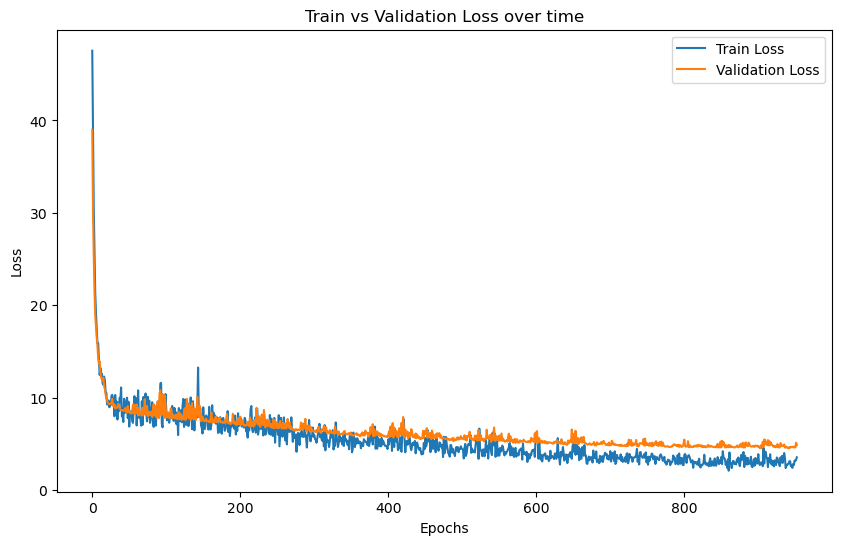

In [21]:
# Convert the history to a pandas dataframe
df_loss_history = pd.DataFrame(loss_history, columns=['train_loss', 'val_loss'])

# plot train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(df_loss_history['train_loss'], label='Train Loss')
plt.plot(df_loss_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over time')
plt.legend()
plt.show()


### Evaluation

In [22]:
test_true = test_lmrk
test_pred = model.predict(test_img)

print("MAE: ", l1_loss(test_true, test_pred).numpy())

MAE:  4.496098


### visualize result

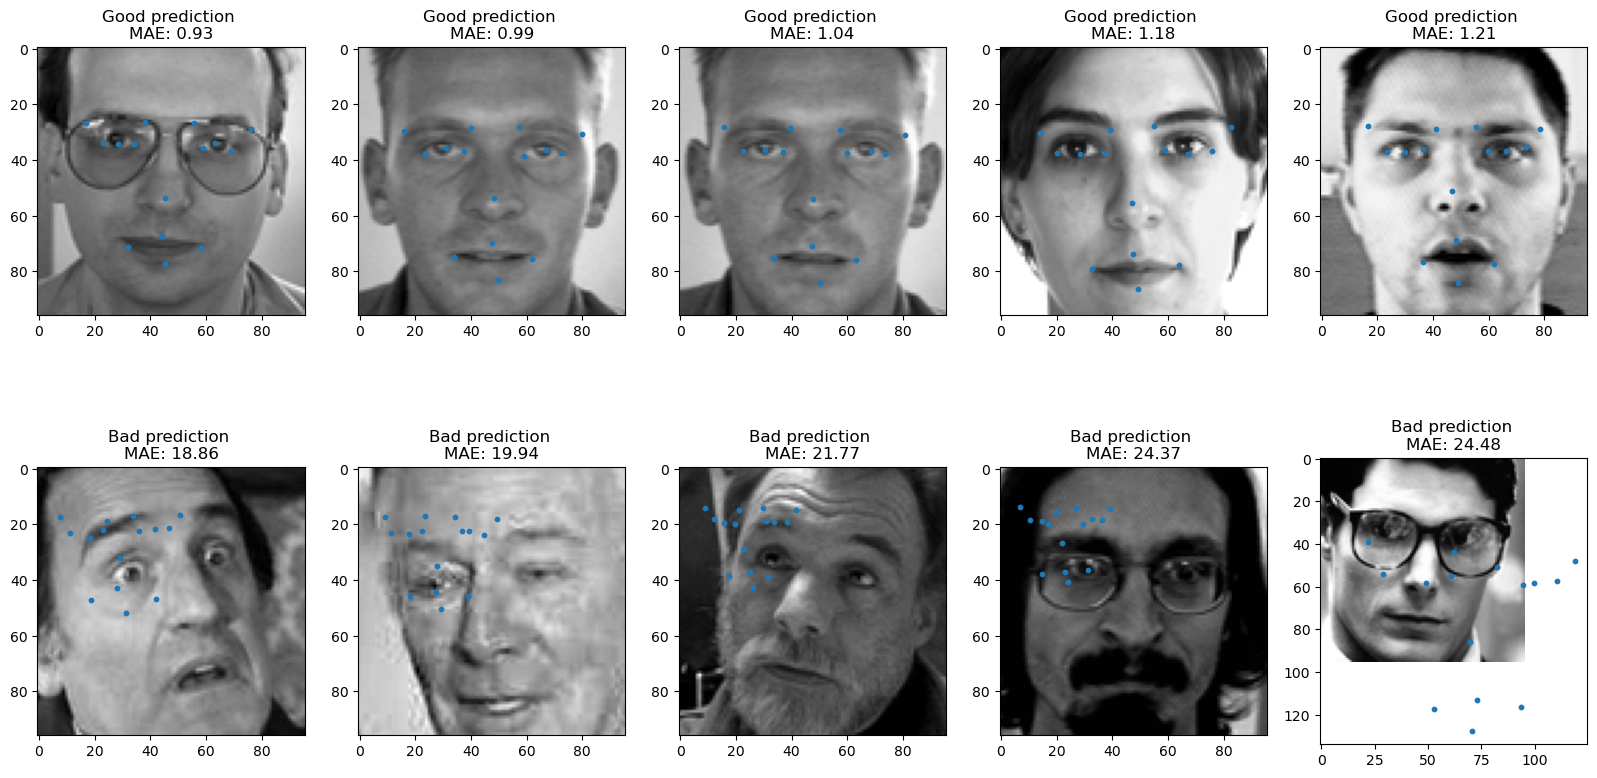

In [23]:
def plot_sample(image, landmarks, ax):
    ax.imshow(image, cmap='gray')
    landmarks = np.reshape(landmarks, (-1, 2)) # reshape to (15, 2)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='o', s=10)

# suppose we have some predictions and ground truth data
predictions = model.predict(test_img)
ground_truth = test_lmrk  # assume this exists

errors = np.mean(np.abs(predictions - ground_truth), axis=1)
sorted_indices = np.argsort(errors)

# Indices of good predictions
good_indices = sorted_indices[:5]  

# Indices of bad predictions
bad_indices = sorted_indices[-5:]  

fig = plt.figure(figsize=(20,10))
for i in range(5):
    # Good predictions
    ax = fig.add_subplot(2, 5, i+1)
    plot_sample(test_img[good_indices[i]], predictions[good_indices[i]], ax)
    ax.set_title("Good prediction \nMAE: {:.2f}".format(errors[good_indices[i]]))

    # Bad predictions
    ax = fig.add_subplot(2, 5, i+6)
    plot_sample(test_img[bad_indices[i]], predictions[bad_indices[i]], ax)
    ax.set_title("Bad prediction \nMAE: {:.2f}".format(errors[bad_indices[i]]))

plt.show()
